# Introgression 

**Jerome Kelleher and Konrad Lohse**

There has been great interest in understanding the contributions past populations have made to the genetic diversity of current populations via admixture. In particular, the availability of whole genome sequence data from archaic hominins (Green et al 2010) has allowed geneticists to identify admixture tracks (Sankararaman 2016). In the simplest case, admixture tracts can be defined heuristically as regions of the genome that show excessive similarity between a putative source and a recipient population (usually quantified relative to some non-admixted reference population, ref Durand et al 2010). Because recombination breaks down admixture tracts, their length distribution gives a clock for calibrating admixture and this information been used to date the admixure contributions Neanderthals and other archaic hominins have made to non-African humans (Sankararaman 2016) and to recontruct the admixture history between different modern human populations (ref).

Crucially, the power to identify admixture depends on the relative time bewteen the admixture event and the earlier divergence between source and the recipient population: the shorter this interval, the harder it becomes to detect admixture. This is because ancestral material is increasingly likely to trace its ancestry back to the common ancestral population regardless of whether it has been involved in any recent admixture or not. In other words, it becomes increasingly difficult to distinguish between admixtjure from Incomplete lineage sorting (ILS).

In the following section we use msprime simulations to ask what fraction of admixture tracts are identifyable as such. 

To illustrate this, we simulate ancestral recombination graphs (ARGs) under a simple toy history of divergence and admixture which is loosely motivated by the demographic history of modern humans and Neandertals. As in previous sections, we will first examine properties of the ARG directly rather than use it to simulate mutations. We assume a minimal sample of a single (haploid) genome from a modern human population in African and Eurasia as well as an ancient Neandertal sample.

Considering a rooted ARG, we want to distinguish three categories of segments: i) tracts actually involved in Neandertal admixture, ii) the subset of those tracts that coalesces in the Neandertal population and iii) segments at which Eurasians are more closely related to Neandertals than either are to Africans. This latter category must include all of ii) but also an additional set of short tracts that are due to incomplete lineage sorting (ILS). The last category is interesting because it is the only one that can be unambiguously detected in data (via derived mutations that are shared by Neandertals and Eurasians).

First we set up a highly simplified demographic history of human neandertal demography and simulate a single chromosome of 20Mb length:

In [1]:
import random
import collections
import msprime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import SVG

In [2]:
# Population IDs: Africa, Eurasia, Neanderthal
AFR, EUR, NEA = 0, 1, 2
    
def run_simulation(random_seed=None):   
    time_units = 1000 / 25  # Conversion factor for kya to generations
    ts = msprime.simulate(
        Ne=10**4,  # The same for all populations; highly unrealistic!
        recombination_rate=1e-8,
        length=20 * 10**6,  
        samples=[
            msprime.Sample(time=0, population=AFR),
            msprime.Sample(time=0, population=EUR),
            # Neanderthal sample taken 30 kya
            msprime.Sample(time=30 * time_units, population=NEA),
        ],
        population_configurations = [
            msprime.PopulationConfiguration(), # Africa
            msprime.PopulationConfiguration(), # Eurasia
            msprime.PopulationConfiguration(), # Neanderthal
        ],
        demographic_events = [
            msprime.MassMigration(
                # 2% introgression 50 kya
                time=50 * time_units,
                source=EUR, dest=NEA, proportion=0.02),
            msprime.MassMigration(
                # Eurasian & Africa populations merge 70 kya
                time=70 * time_units, 
                source=EUR, dest=AFR, proportion=1),
            msprime.MassMigration(
                # Neanderthal and African populations merge 300 kya
                time=300 * time_units,
                source=NEA, destination=AFR, proportion=1),
        ],
        record_migrations=True,  # Needed for tracking segments.
        random_seed=random_seed,
    )
    return ts

ts = run_simulation(1)

Here we run our simulation in the usual way, but including the ``record_migrations`` option. This allows us to track segments of ancestral material that migrate from the European population into the Neanderthal population (backwards in time). We can then examine the length distributions of these segments and compare them with the length of the segments that also go on to coalesce within the Neanderthal population.

In [3]:
def get_migrating_tracts(ts):
    migrating_tracts = []
    # Get all tracts that migrated into the neanderthal population
    for migration in ts.migrations():
        if migration.dest == NEA:
            migrating_tracts.append((migration.left, migration.right))
    return np.array(migrating_tracts) 

def get_coalescing_tracts(ts):
    coalescing_tracts = []
    tract_left = None
    for tree in ts.trees():    
        # 1 is the Eurasian sample and 2 is the Neanderthal
        mrca_pop = tree.population(tree.mrca(1, 2))
        left = tree.interval[0]
        if mrca_pop == NEA and tract_left is None:
            # Start a new tract
            tract_left = left      
        elif mrca_pop != NEA and tract_left is not None:
            # End the last tract
            coalescing_tracts.append((tract_left, left))
            tract_left = None
    if tract_left is not None:
        coalescing_tracts.append((tract_left, ts.sequence_length))
    return np.array(coalescing_tracts)

def get_eur_nea_tracts(ts):
    tracts = []
    tract_left = None
    for tree in ts.trees():    
        # 1 is the Eurasian sample and 2 is the Neanderthal
        mrca = tree.mrca(1, 2)
        left = tree.interval[0]
        if mrca != tree.root and tract_left is None:
            # Start a new tract
            tract_left = left      
        elif mrca != tree.root and tract_left is not None:
            # End the last tract
            tracts.append((tract_left, left))
            tract_left = None
    if tract_left is not None:
        tracts.append((tract_left, ts.sequence_length))
    return np.array(tracts)

                                    
migrating = get_migrating_tracts(ts)
within_nea = get_coalescing_tracts(ts)
eur_nea = get_eur_nea_tracts(ts)

We build three different lists. The first is the set of tracts that have migrated from the Eurasian population into the Neanderthal population, and is done simply by finding all migration records in which the destination population is equal to NEA. The second list (which must contain a subset of the segments in the first list) is the ancestral segments that went on to coalesce within the Neanderthal population. The third list contains all segments in which the Eurasian and Neanderthal sample coalesce before their ancestor coalesces with the African sample. The third list includes both Eurasian segments that migrated to the Neanderthal population and segments that did not migrate and did not coalesce until after the Neanderthal-Human population split 300kya.

In [4]:
nea_total = np.sum(eur_nea[:,1] - eur_nea[:,0])
migrating_total = np.sum(migrating[:,1] - migrating[:,0])
within_nea_total = np.sum(within_nea[:,1] - within_nea[:,0])
print([nea_total, migrating_total, within_nea_total])

[10077464.05508275, 316645.8476603916, 164413.62338078953]


Although $f=0.02$ the total length of admixted segments is 5% of the chromosome. Presumably this excess is just due to coalescence variance? We expect a proportion $1-e^{-(T_{split}-T_{ad})}$ of admixted lineages to coalesce. Given our time parameters $T_{split}-T_{ad})= 1/2$ (in units of $2 N_e$ generations), so we expect $1 -(e^-\frac{1}{2})=0.39$ of admixted sequence to have a coalesce in the neandertal population. Why is the observed fraction just 0.029?

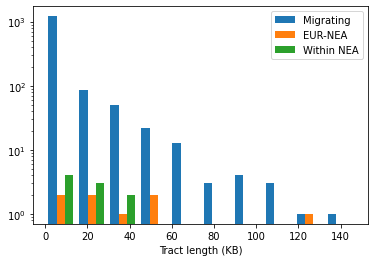

In [5]:
kb = 1 / 1000
plt.hist([
    (eur_nea[:,1] - eur_nea[:,0]) * kb,
    (migrating[:,1] - migrating[:,0]) * kb,   
    (within_nea[:,1] - within_nea[:,0]) * kb,],    
    label=["Migrating", "EUR-NEA", "Within NEA"]
)
plt.yscale('log')
plt.legend()
plt.xlabel("Tract length (KB)");

Plotting these tract lengths for a single replicate shows that, as expected, admixture tracts are large initially (blue). We can also see that there is extensive ILS which has two effects: First, only a subset  of the admixted material has ancestry in the Neandertal population, it would to check whether this fits the total lengths}). Second there many more tracts at which Neandertals and non-African humans are more closely related to each other due to incomplete lineage sorting (ILS) than there are admixture tracts. Finally ILS tracts because they are old by definition  are substantially shorter than admixture tracts.

## Locating mutations

We are interested in finding the population in which mutations arose. Because mutations are just associated with a specific tree node in msprime, we must simulate some extra information in order to make this question answerable. This is quite straightforward to do, since we can generate a time for each mutation uniformly along a branch and therefore unambiguously locate it time (and, therefore, space).

```{todo}
We don't need to simulate times any more
```

In [6]:
def simulate_mutation_times(ts, random_seed=None):
    rng = random.Random(random_seed)
    mutation_time = np.zeros(ts.num_mutations)
    for tree in ts.trees():
        for mutation in tree.mutations():
            a = tree.time(mutation.node)
            b = tree.time(tree.parent(mutation.node))
            mutation_time[mutation.id] = rng.uniform(a, b)
    return mutation_time

pop_configs = [
    msprime.PopulationConfiguration(sample_size=3),
    msprime.PopulationConfiguration(sample_size=1),
    msprime.PopulationConfiguration(sample_size=1)]
M = [
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]]
ts  = msprime.simulate(
    population_configurations=pop_configs, migration_matrix=M,
    record_migrations=True, mutation_rate=0.5, random_seed=25)
mutation_time = simulate_mutation_times(ts, random_seed=25)

Once we have run our simulation and assigned times to each mutation, we can then assign populations to each of these mutations. The following function takes a simple approach, but first gathering the migrations for each node into a list. Then, for every mutation, we sequentially examine each migration that affects the mutation's node and intersects with the site position. Because we know that the migration records are sorted in increasing time order, we can simply apply the effects of each migration while the migration record's time is less than the time of the mutation. At the end of this process, we then return the computed mapping of mutation IDs to the populations in which they arose.

In [7]:
def get_mutation_population(ts, mutation_time):
    node_migrations = collections.defaultdict(list)
    for migration in ts.migrations():
        node_migrations[migration.node].append(migration)
    mutation_population = np.zeros(ts.num_mutations, dtype=int)
    for tree in ts.trees():
        for site in tree.sites():
            for mutation in site.mutations:                
                mutation_population[mutation.id] = tree.population(mutation.node)
                for mig in node_migrations[mutation.node]:
                    # Stepping through all migations will be inefficient for large 
                    # simulations. Should use an interval tree (e.g. 
                    # https://pypi.python.org/pypi/intervaltree) to find all 
                    # intervals intersecting with site.position.
                    if mig.left <= site.position < mig.right:
                        # Note that we assume that we see the migration records in 
                        # increasing order of time!
                        if mig.time < mutation_time[mutation.id]:
                            assert mutation_population[mutation.id] == mig.source
                            mutation_population[mutation.id] = mig.dest
    return mutation_population

mutation_population = get_mutation_population(ts, mutation_time)

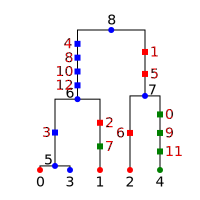

In [8]:
tree = ts.first()
colour_map = {0:"red", 1:"blue", 2: "green"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
mutation_colours = {mut.id: colour_map[mutation_population[mut.id]] for mut in tree.mutations()}
SVG(tree.draw(node_colours=node_colours, mutation_colours=mutation_colours))
    

This example shows the locations in which the mutations along the tree branches. We show a single tree here for simplicity, but the method also works when we have recombination.